## Tensor 模块

PyTorch中最常用的模块包括：

|模块|描述|
|:-:|:-:|
|torch|类似Numpy，但支持GPU加速|
|torch.autograd|自动求导模块|
|torch.nn|神经网络模块，定义了大量搭建神经网络所需的layer和loss|
|torch.optim|优化算法模块，实现了常用的优化算法，如SGD，Adam，L-BFGS等等|
|torch.utils|定义了一些常用的接口，如数据加载（DataLoader）|

什么情况下可以使用PyTorch：

* 需要大量的矩阵运算，使用GPU来进行加速。复杂的矩阵运算，如求特征值并不适用PyTorch
* 构建深度学习模型

In [1]:
import torch

In [2]:
x = [[1, 2], [3, 4]]
y = torch.tensor(x)
print(y,y.type)

tensor([[1, 2],
        [3, 4]]) <built-in method type of Tensor object at 0x000002707EB32780>


In [3]:
print(torch.zeros(2,3))
print(torch.ones(2,3))

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


In [4]:
x = torch.LongTensor(2, 3)
x.fill_(-1)
print(x.type(), x.dtype)
print(x)
y = x.int()
z = x.float()
print(y.dtype, z.dtype)

torch.LongTensor torch.int64
tensor([[-1, -1, -1],
        [-1, -1, -1]])
torch.int32 torch.float32


In [5]:
x = torch.rand(3, 4)
y = x.cuda()
print(x.type(), y.type())

AssertionError: Torch not compiled with CUDA enabled

In [6]:
x = torch.rand(2, 3, 4)
print(x[1].shape)

y = x[1, 0:2, :]
print(y.shape)

z = x[:, 0, ::2]
print(z.shape)

torch.Size([3, 4])
torch.Size([2, 4])
torch.Size([2, 2])


In [7]:
z

tensor([[0.5769, 0.3209],
        [0.7213, 0.1923]])

In [8]:
x = torch.rand(3, 1, 2)
y = x.view(2, 3)
print(x.shape, y.shape)

torch.Size([3, 1, 2]) torch.Size([2, 3])


In [9]:
x = torch.rand(3, 1, 2)
print(x)
print(x.resize_(4))
print(x.resize_(6))
print(x.resize_(3, 3))

tensor([[[0.7497, 0.5946]],

        [[0.7770, 0.2355]],

        [[0.5024, 0.4001]]])
tensor([0.7497, 0.5946, 0.7770, 0.2355])
tensor([0.7497, 0.5946, 0.7770, 0.2355, 0.5024, 0.4001])
tensor([[ 7.4970e-01,  5.9458e-01,  7.7701e-01],
        [ 2.3552e-01,  5.0245e-01,  4.0006e-01],
        [ 0.0000e+00,  1.6105e+00, -3.6893e+19]])


In [10]:
x = torch.rand(3, 2, 2)
y = x.squeeze()
z1 = x.unsqueeze(3) # 在第4维度插入内存
z2 = x.unsqueeze(1) # 在第2维度插入内存，原本的第2维度变为第3维
print(x.shape, y.shape, z1.shape, z2.shape)

torch.Size([3, 2, 2]) torch.Size([3, 2, 2]) torch.Size([3, 2, 2, 1]) torch.Size([3, 1, 2, 2])


In [11]:
z

tensor([[0.5769, 0.3209],
        [0.7213, 0.1923]])

In [12]:
x = torch.rand(3, 2, 4)
y = x.transpose(1, 2)
print(x.shape, y.shape)

torch.Size([3, 2, 4]) torch.Size([3, 4, 2])


## 自动求导

In [13]:
import torch
from torch.autograd import Variable

# 定义变量 x
x = Variable(torch.Tensor([3]), requires_grad=True)

# 定义函数
f = x*x - x

# 求导数
f.backward()

print(x)
print('f(x)=', f.data[0])
print('f\'(3)=', x.grad.data[0])

tensor([3.], requires_grad=True)
f(x)= tensor(6.)
f'(3)= tensor(5.)


In [14]:
value = torch.Tensor([1, 2])
x = Variable(value, requires_grad=True)
print(x.data is value)

False


In [15]:
y = x + x
z = x**3
print(y.grad_fn)
print(z.grad_fn)

In [16]:
print(x.is_leaf, y.is_leaf)
print(x.grad_fn, y.grad_fn)
print(y.grad_fn.next_functions)

True False
None <AddBackward0 object at 0x000002707EB34820>
((<AccumulateGrad object at 0x000002707EB34640>, 0), (<AccumulateGrad object at 0x000002707EB34640>, 0))


In [17]:
x = Variable(torch.Tensor([1]), requires_grad=True)
y = x + x       # 计算图1
z = x**3        # 计算图2

# 第一次求导
y.backward()
print(x.grad.data)	# dy/dx = 2

# 第二次求导
z.backward()
print(x.grad.data)	# dy/dx + dz/dx = 2+3 = 5

tensor([2.])
tensor([5.])


In [18]:
x = Variable(torch.Tensor([1, 2, 3]), requires_grad=True)
y = x*x
f = y.sum()
df = torch.autograd.grad(f, x, create_graph=True)
	# create_graph = True 会对反向传播构建计算图，用于计算二阶导数
print(df[0])

tensor([2., 4., 6.], grad_fn=<AddBackward0>)


In [19]:
from torch.autograd import Function
class MulAdd(Function):
    @staticmethod
    def forward(self,x,w,b):
        self.save_for_backward(w,x)
        output = w * x + b
        return output
    
    @staticmethod
    def backward(self, grad_output):
        w,x = self.saved_variables
        grad_x = grad_output * w
        grad_w = grad_output * x 
        grad_b = grad_output * 1
        return grad_x, grad_w,grad_b

In [20]:
x = torch.tensor(1.0)
w = torch.tensor(2.0,requires_grad = True)
b = torch.tensor(3.0,requires_grad = True)
z=MulAdd.apply(x, w, b)
z.backward()
print(x.grad, w.grad, b.grad)

None tensor(1.) tensor(1.)


<ipython-input-19-64bc6b482c13>:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  w,x = self.saved_variables


## 优化器

In [21]:
import torch
from torch.autograd import Variable
from torch.autograd import Function

import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
def rosenbrock(x):
    y = 100*(x[1]-x[0]*x[0])**2 + (x[0]-1)**2
    return y
# 随机初始化
value = torch.rand(2)
# 要优化的变量
x = Variable(value,requires_grad=True)
y = rosenbrock(x)
# 定义优化器，这里选择随机梯度法
optimizer = torch.optim.SGD(params=[x],lr=0.001) # params=x 会报错
nstep = 10
for i in range(nstep):
    optimizer.zero_grad()
    y = rosenbrock(x)
    y.backward()
    optimizer.step()
    print('iter: %d\t fun_val: %.2e' % (i,y.data))

In [23]:
x0 = torch.rand(2)
x = Variable(x0.clone(), requires_grad=True)
sgd = torch.optim.SGD(params=[x], lr=0.003)

y_sgd = []
for i in range(500):
    sgd.zero_grad()
    y = rosenbrock(x)
    y.backward()
    sgd.step()
    y_sgd.append(y.data)

print('converged solution (%.2e,%.2e)' % (x.data[0],x.data[1]))   

converged solution (7.90e-01,6.14e-01)


In [24]:
x = Variable(x0.clone(), requires_grad=True)
adam = torch.optim.SGD(params=[x], lr=0.003)

y_adam = []
for i in range(500):
    adam.zero_grad()
    y = rosenbrock(x)
    y.backward()
    adam.step()
    y_adam.append(y.data)

print('converged solution (%.2e,%.2e)' % (x.data[0],x.data[1]))

converged solution (7.90e-01,6.14e-01)


Text(0.5, 0, 'number of iteration')

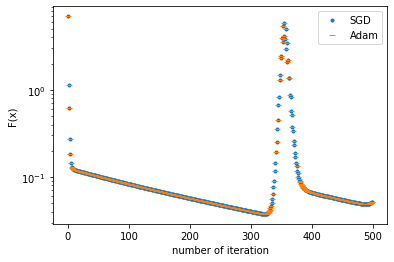

In [25]:
plt.semilogy(y_sgd, '.', label='SGD')
plt.semilogy(y_adam, '_', label='Adam')
plt.legend()
plt.ylabel('F(x)')
plt.xlabel('number of iteration')

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 6, 3)
        
    def forward(self, x):
        out = self.conv2(self.conv1(x))
        return out
    
net = Net()

x = Variable(torch.randn(1, 3, 5, 5))
net(x)

tensor([[[[ 0.3924]],

         [[ 0.1048]],

         [[ 0.0376]],

         [[-0.2245]],

         [[ 0.0465]],

         [[-0.8375]]]], grad_fn=<MkldnnConvolutionBackward>)

In [27]:
# 设置第一层的学习率为 0.1 ，第二层为 0.01
optimizer = torch.optim.SGD([
    {'params': net.conv1.parameters()}, # predict 的学习率为 0.1
    {'params': net.conv2.parameters(), 'lr': 0.01}
], lr=0.1) # hidden 层学习率为 0.01

## 神经网络模块

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# 返回一个函数
f = nn.Linear(2, 2)

# 输入必须是 VAriable 
x = Variable(torch.Tensor([[3, 4]]))
y = f(x)
print(y)

# 查看参数 w, b
for name, parameters in f.named_parameters():
    print(name, parameters)

tensor([[ 1.9596, -3.2064]], grad_fn=<AddmmBackward>)
weight Parameter containing:
tensor([[ 0.2703,  0.4522],
        [-0.4450, -0.3892]], requires_grad=True)
bias Parameter containing:
tensor([-0.6599, -0.3146], requires_grad=True)


In [29]:
print('type of weight:',type(f.weight),'\n')

f.weight.data = torch.Tensor([[1,2],[5,6]])    # W
print(f.weight.data)
f.bias.data = torch.Tensor([1,1])              # b
print(f.bias.data)
y = f(x)                                       # y = Wx+b
print(y)

type of weight: <class 'torch.nn.parameter.Parameter'> 

tensor([[1., 2.],
        [5., 6.]])
tensor([1., 1.])
tensor([[12., 40.]], grad_fn=<AddmmBackward>)


In [30]:
net = nn.Conv2d(10, 5, kernel_size=3, stride=1, padding=1)
x = Variable(torch.rand(4, 10, 28, 28))
print(x.shape)
y = net(x)
print(y.data.shape)

torch.Size([4, 10, 28, 28])
torch.Size([4, 5, 28, 28])


In [31]:
avgpool_1 = nn.AvgPool2d(3)
avgpool_2 = nn.AvgPool2d(3,stride=2)
maxpool = nn.MaxPool2d(3)
x = Variable(torch.rand(3, 3, 9, 9))
y1 = avgpool_1(x)
y2 = avgpool_2(x)
y3 = maxpool(x)

print(y1.data.shape)
print(y2.data.shape)
print(y3.data.shape)

torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 4, 4])
torch.Size([3, 3, 3, 3])


In [32]:
# 线性回归
x = Variable(torch.randn(2, 2))
f = nn.Linear(2, 3)
y = f(x)

# BatchNorm 3 channel
bn = nn.BatchNorm1d(3)
bn.weight.data = torch.ones(3)  # 初始化标准差为 1
bn.bias.data = torch.zeros(3)   # 均值为 0
b_output = bn(y)
print(b_output)

tensor([[-0.9985,  1.0000,  0.9999],
        [ 0.9985, -1.0000, -0.9999]], grad_fn=<NativeBatchNormBackward>)


In [33]:
# 假设每个元素以 0.5 的概率被舍弃
dropout = nn.Dropout(0.5)
d_output = dropout(b_output)
print(d_output)

tensor([[-1.9971,  1.9999,  0.0000],
        [ 0.0000, -0.0000, -1.9999]], grad_fn=<MulBackward0>)


In [34]:
# Inplace operation
relu1 = nn.ReLU(inplace=True)
x = Variable(torch.Tensor([[1, -10]]))
y1 = relu1(x)
print('Inplace operation:')
print('y=',y1.data,'x=',x.data) # y1.data 其实就是 x.data

Inplace operation:
y= tensor([[1., 0.]]) x= tensor([[1., 0.]])


In [35]:
# non-inplace operation
relu2 = nn.ReLU(inplace=False)
x = Variable(torch.Tensor([[1, -10]]))
y2 = relu2(x)
print('non-inplace operation:')
print('y=',y2.data,'x=',x.data) # y2.data 是新分配的张量

non-inplace operation:
y= tensor([[1., 0.]]) x= tensor([[  1., -10.]])


In [36]:
loss = nn.MSELoss(size_average=True)
B = 10
d = 20

x1 = Variable(torch.ones(B, d))
x2 = Variable(-torch.ones(B, d))

error = loss(x1, x2)
print(error)

tensor(4.)


D:\Python\python\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [37]:
print(x1)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])


In [38]:
loss = nn.MSELoss(size_average=False)
B = 10
d = 20

x1 = Variable(torch.ones(B, d))
x2 = Variable(-torch.ones(B, d))

error = loss(x1, x2)
print(error)

tensor(800.)


D:\Python\python\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt

from torch.nn import init
linear = nn.Linear(3, 4)
print(init.xavier_normal(linear.weight))

Parameter containing:
tensor([[ 0.7032,  0.3665, -0.6144],
        [ 0.7639,  0.3077,  0.5412],
        [-0.6325, -0.7634,  0.1853],
        [-0.6666,  0.2212, -0.8316]], requires_grad=True)


<ipython-input-39-58432eca0c37>:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  print(init.xavier_normal(linear.weight))


In [40]:
import math
linear = nn.Linear(3, 4)
print(linear.weight.data.normal_(0, 1))

tensor([[ 2.1356,  1.7108, -0.1343],
        [ 0.0705,  0.1797,  0.0643],
        [-0.5914,  0.3744, -0.2870],
        [-1.1299,  1.1970,  1.1133]])


In [41]:
class Linear(nn.Module):
    def __init__(self,in_features,out_features,bias=True):
        super(Linear,self).__init__()
        ...
        
    def forward(self,input):
        return F.linear(input,self.weight,self.bias)

In [43]:
class Example(nn.Module):
    def __init__(self):
        super(Example,self).__init__()
        self.param = nn.Parameter(torch.randn(2, 2))
        self.submodel = nn.Linear(2, 3)
        
    def forward(self,x):
        y = self.param.mm(x)
        y = self.submodel(y)
        return y
    
example = Example()
example

Example(
  (submodel): Linear(in_features=2, out_features=3, bias=True)
)

In [44]:
example._parameters

OrderedDict([('param',
              Parameter containing:
              tensor([[-0.2597, -0.2195],
                      [-0.4554,  0.4051]], requires_grad=True))])

In [45]:
example._modules

OrderedDict([('submodel', Linear(in_features=2, out_features=3, bias=True))])

In [46]:
for name, param in example.named_parameters():
    print(name, param.size())

param torch.Size([2, 2])
submodel.weight torch.Size([3, 2])
submodel.bias torch.Size([3])


In [49]:
print(getattr(example,'training'))
print(example.training,'\n')
print(getattr(example,'param'))
print(example.__getattr__('param'),'\n')
setattr(example,'param1',torch.randn(2, 2))

True
True 

Parameter containing:
tensor([[-0.2597, -0.2195],
        [-0.4554,  0.4051]], requires_grad=True)
Parameter containing:
tensor([[-0.2597, -0.2195],
        [-0.4554,  0.4051]], requires_grad=True) 



In [50]:
x = Variable(torch.randn(2, 3))

# torch.nn.Conv2d
f = nn.Linear(3, 4)
output1 = f(x)

# torch.nn.functional.Conv2d
output2 = nn.functional.linear(x, f.weight, f.bias)
output1 == output2

tensor([[True, True, True, True],
        [True, True, True, True]])

In [51]:
class QuadActiveFunc(nn.Module):
    def __init__(self,a=0.5,inplace=True):
        super(QuadActiveFunc, self).__init__()
        self.a = a
        self.inplace = inplace
        
    def forward(self, x):
        if self.inplace:
            x = self.a*x*x
            return x
        else:
            return self.a*x*x
        
acFunc = QuadActiveFunc()
x = Variable(torch.ones(3, 4) * 3)
y = acFunc(x)

print(x)
print(y)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[4.5000, 4.5000, 4.5000, 4.5000],
        [4.5000, 4.5000, 4.5000, 4.5000],
        [4.5000, 4.5000, 4.5000, 4.5000]])


In [52]:
x = Variable(torch.Tensor([1, 2]),requires_grad=True)
acFunc1 = QuadActiveFunc(a=1)
y = acFunc1(x)
S = y.sum()
S.backward()

print('x1*x1 + x2*x2 = ',S.data)
print('grad:',x.grad.data)

x1*x1 + x2*x2 =  tensor(5.)
grad: tensor([2., 4.])


## 数据加载与处理

In [53]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import torch 
from torch.utils.data import DataLoader

import torchvision.datasets as dsets
import torchvision.transforms as trans

In [55]:
# 加载MNIST数据

# 参数 train=True，加载训练数据，否则加载的是测试数据
train_set = dsets.MNIST(root='./data/mnist',train=True,
                        transform=trans.ToTensor(),download=True)
test_set = dsets.MNIST(root='./data/mnist',train=False,
                       transform=trans.ToTensor(),download=True)

# 用迭代器封装数据
# 第三个参数: shuffle = True 表示每个epoch开始前都会打乱数据的顺序
train_loader = DataLoader(train_set,batch_size=10,shuffle=True)
test_set = DataLoader(test_set,batch_size=10,shuffle=False)

100.1%

Extracting ./data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw


113.5%

Extracting ./data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw


100.4%

Extracting ./data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw


180.4%

Extracting ./data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw
Processing...
Done!


batch data shape: torch.Size([10, 1, 28, 28])
visualize the data


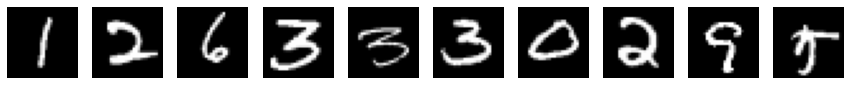

In [56]:
for batch_x,batch_y in train_loader:
    break

# 输出的维数为 NxCxWxH 第二个维度是channel数量，这和Numpy里面正常
# 的channel的位置不太一样
print('batch data shape:',batch_x.shape)

print('visualize the data')
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch_x[i][0].numpy(),cmap='gray');
    plt.axis('off')

In [ ]:
train_set = dsets.CIFAR10(root='./data/cifar10',train=True,
                        transform=trans.ToTensor(),download=True)
test_set = dsets.CIFAR10(root='../data/cifar10',train=False,
                       transform=trans.ToTensor(),download=True)

train_loader = DataLoader(train_set,batch_size=100,shuffle=True)
test_loader = DataLoader(test_set,batch_size=100,shuffle=False)

1.2%

In [ ]:
batch_x,batch_y = iter(train_loader).next()
print('batch data shape:',batch_x.shape)
idx2class = ['airplane','automobile','bird','cat','deer',
             'dog','frog','horse','ship','truck']

print('visualize the data')
indices = torch.rand(10).fill_(-1).long()
cnt = 0
for i in range(100):
    label = batch_y[i]
    if indices[label] == -1:
        indices[label]=i
        cnt += 1
    if cnt == 10:
        break

plt.figure(figsize=(15,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    img = batch_x[indices[i]].numpy().transpose([1,2,0])
    plt.imshow(img)
    plt.title('%d:%s'%(i,idx2class[i]))
    plt.axis('off')

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import torch 
from torch.utils.data import DataLoader

import torchvision.datasets as dsets
import torchvision.transforms as trans

In [2]:
class MyDataset:
    def __init__(self,X,y):
        assert X.size(0) == y.size(0)
        self.X = X
        self.y = y

    def __getitem__(self,idx):
        # 这个部分的数据也可以是从硬盘中读
        # 出来的
        bx = self.X[idx]
        by = self.y[idx]
        # 这里个在对 bx 和 by 做一些处理，
        # 譬如标准化，图片变换等等。从而实
        # 现数据增强

        return bx, by

    def __len__(self):
        return self.X.size(0)

X = torch.rand(100,2,30,30)
y = torch.rand(100)

dataset = MyDataset(X,y)
dataloader = torch.utils.data.DataLoader(
                            dataset=dataset,
                            batch_size = 10,
                            shuffle = False)

for i,(bx,by) in enumerate(dataloader):
    print(i+1,bx.size(),by.size())

1 torch.Size([10, 2, 30, 30]) torch.Size([10])
2 torch.Size([10, 2, 30, 30]) torch.Size([10])
3 torch.Size([10, 2, 30, 30]) torch.Size([10])
4 torch.Size([10, 2, 30, 30]) torch.Size([10])
5 torch.Size([10, 2, 30, 30]) torch.Size([10])
6 torch.Size([10, 2, 30, 30]) torch.Size([10])
7 torch.Size([10, 2, 30, 30]) torch.Size([10])
8 torch.Size([10, 2, 30, 30]) torch.Size([10])
9 torch.Size([10, 2, 30, 30]) torch.Size([10])
10 torch.Size([10, 2, 30, 30]) torch.Size([10])


In [3]:
# 删除损坏样本
class DelDataset(MyDataset):
    def __getitem__(self, idx):
        try:
            # 调用之前的获取函数，即 MyDataset.__getitem__(self, index)
            return super(DelDataset,self).__getitem__(idx)

        except:
            return None, None

# 导入默认的拼接方式
from torch.utils.data.dataloader import default_collate
def new_collate_fn(batch):
    # 删除为None的数据
    batch = list(filter(lambda x:x[0] is not None, batch))
    if len(batch) == 0:
        return t.Tensor()
    else:
        # 用默认方式拼接过滤后的batch数据
        return default_collate(batch)

In [4]:
# 代替损坏样本
class ReplaceDataset(MyDataset):
    def __getitem__(self, idx):
        try:
            return super(ReplaceDataset, self).__getitem__(idx)
        except:
            new_idx = random.randint(0,len(self)-1)
            return self[new_idx]

## 线性回归模型

In [6]:
# 加载包
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision.datasets as dsets
import torchvision.transforms as trans

# 加载数据
batch_size = 1000

train_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=True,download=True)
test_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=False,download=True)
train_dl = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set,batch_size=batch_size)

INPUT_DIM = 28*28 
N_CLASSES = 10 
nsample = 60000
GAMMA = 1e-5
lr = 1e-2
nepochs = 30

# 模型参数
W = Variable(
    torch.Tensor(INPUT_DIM,N_CLASSES).normal_(0,0.01),
    requires_grad=True
)
b = Variable(
    torch.Tensor(1,N_CLASSES).zero_(),
    requires_grad = True
)

# 定义优化算法 Optimizer
optimizer = torch.optim.SGD([W,b],lr=lr,momentum=0)

# 选择学习率下降策略
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[10,15,25])

# Cost 函数
def J(x,y):
    pred = x.matmul(W) + b
    cost = (pred-y).pow(2).mean() + GAMMA * W.pow(2).sum()
    return cost

# index的shape需要与x的shape对应，以保证index中每个元素都能指定x中的一个位置进行填充。
# dim=0表示按行填充，例如：index中第0行第1列的index=2，表示x中(2,1)的位置填充1。
x = torch.zeros(3, 5)
x.scatter_(0, torch.LongTensor([[1,2,0,0,1],[2,1,0,2,1]]), 1)

def create_variable(x,y):
    n = x.size(0)
    x = x.view(n,INPUT_DIM)
    y_onehot = torch.Tensor(n,N_CLASSES)
    y_onehot.zero_()
    y_onehot.scatter_(1,y.view(-1,1),1)

    x = Variable(x)
    y = Variable(y_onehot)
    return x,y

# 预测函数
def pred(x):
    x = x.view(x.size(0),-1)
    o = x.matmul(W.data)+b.data
    probs,labels = o.max(dim=1)
    return probs,labels

# 评价函数：根据准确率对模型进行评价
def evaluate(dl):
    correct = 0
    total = 0
    for batch_x,batch_y in dl:
        _,batch_pred = pred(batch_x)
        correct += (batch_pred==batch_y).sum()
        total += batch_y.size(0)
    accuracy = 100.0*correct/total
    return accuracy

# 训练函数： 训练优化模型参数
def train_epoch(dl):
    error = 0
    for batch_x,batch_y in dl:
        x,y = create_variable(batch_x,batch_y)
        # 前向传播，计算损失
        loss = J(x,y)
        # 后向传播，计算导数
        loss.backward()
        # 参数更新
        optimizer.step()

        error += loss.data
    error /= len(dl)
    return error

for epoch in range(nepochs):
    # 返回当前的学习率
    current_lr = scheduler.get_lr()[0]
    scheduler.step()
    
    err = train_epoch(train_dl)
    acc_test = evaluate(test_dl)
    acc_train = evaluate(train_dl)

    print('%d/%d, lr=%.2e, train loss: %.2e, train acc: %.2f, test acc: %.2f'%(
                epoch+1,nepochs,current_lr,err,acc_train,acc_test))

In [26]:
# 加载包与数据
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as trans
import numpy as np

batch_size = 1000

train_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=True,download=True)
test_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=False,download=True)
train_dl = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set,batch_size=batch_size)

# 设置参数
INPUT_DIM = 28*28
N_CLASSES = 10
nepochs = 30
lr = 1e-2

# 线性回归模型
class LinearRegression(nn.Module):
    def __init__(self,input_size, num_classes):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

# 显示网络结构
model = LinearRegression(INPUT_DIM, N_CLASSES)
print('网络结构如下：\n', model)

# 损失函数与优化器
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

# 评价函数
def eval(model,criterion,dataloader):
    loss = 0
    accuracy = 0
    #利用enumerate取出一个可迭代对象的内容
    for i, (batch_x, batch_y) in enumerate(dataloader):
        batch_x = Variable(batch_x.view(-1, 28 * 28))
        batch_y = Variable(batch_y)

        outputs = model(batch_x)
        error = criterion(outputs,batch_y)
        loss += error.data

        probs,pred_y = outputs.data.max(dim=1)
        # accuracy += (pred_y==batch_y.data).sum()/batch_y.size(0)
        # accuracy += torch.floor_divide((pred_y==batch_y.data).sum(), batch_y.size(0))
        accuracy += torch.true_divide((pred_y==batch_y.data).sum(), batch_y.size(0))

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

# 训练模型
for epoch in range(nepochs):
    for i, (batch_x, batch_y) in enumerate(train_dl):
        batch_x = Variable(batch_x.view(-1, 28 * 28))
        batch_y = Variable(batch_y)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    tr_loss, tr_acc = eval(model,criterion,train_dl)
    te_loss, te_acc = eval(model,criterion,test_dl)


    print('%d/%d, train loss: %.2e, train acc: %.2f, test loss: %.2e, test acc: %.2f'%(
                epoch+1,nepochs,tr_loss,tr_acc,te_loss,te_acc))

网络结构如下：
 LinearRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


## 全连接神经网络

In [8]:
# 加载模块
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dsets
import torchvision.transforms as trans

    # USE_CUDA = True # 然鹅运行时的电脑是 A 卡，用不上……
USE_CUDA = False

# 加载数据
batch_size = 100

train_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=True,download=True)
test_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=False,download=True)
train_dl = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=6)
test_dl = torch.utils.data.DataLoader(test_set,batch_size=batch_size,num_workers=6)

In [9]:
class FNN(nn.Module):
    def __init__(self,input_size=784,num_classes=10):
        super(FNN,self).__init__()
        self.input_size = input_size
        self.output_size = num_classes
        self.fc1 = nn.Linear(784,500)
        self.fc2 = nn.Linear(500,300)
        self.fc3 = nn.Linear(300,10)

    def forward(self,x):
        o = x.view(-1,784)
        o = self.fc1(o)
        o = F.relu(o)

        o = self.fc2(o)
        o = F.relu(o)

        o = self.fc3(o)
        return o

In [10]:
net2 = nn.Sequential(nn.Linear(784,500),
                     nn.ReLU(),
                     nn.Linear(500,300),
                     nn.ReLU(),
                     nn.Linear(300,10))

In [22]:
def eval(model,criterion,dataloader):
    loss = 0
    accuracy = 0
    for batch_x, batch_y in dataloader:
        batch_x = Variable(batch_x)
        batch_y = Variable(batch_y)
        if USE_CUDA:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()

        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.data
        # 这里存在版本更新

        probs,pred_y = logits.data.max(dim=1)
        # accuracy += (pred_y==batch_y.data).sum()/batch_y.size(0)
        # accuracy += (pred_y==batch_y.data).sum()/batch_y.size(0)
        accuracy += torch.true_divide((pred_y==batch_y.data).sum(), batch_y.size(0))

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

net = FNN(784,10)
optimizer = torch.optim.Adam(net.parameters(),lr=0.01) 
criterion = torch.nn.CrossEntropyLoss()
nepochs = 30

# if USE_CUDA:
#     net = net.cuda()

for epoch in range(nepochs):
    since = time.time()
    for batch_x,batch_y in train_dl:
        batch_x = Variable(batch_x)
        batch_y = Variable(batch_y)
        if USE_CUDA:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()

        optimizer.zero_grad()
        logits = net(batch_x) 
        error = criterion(logits,batch_y)
        error.backward()
        optimizer.step()

    now = time.time()
    tr_loss, tr_acc = eval(net,criterion,train_dl)
    te_loss, te_acc = eval(net,criterion,test_dl)
    print('[%d/%d, %.0f seconds], train error: %.1e, train acc: %.2f\t test error: %.1e, test acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))

[1/30, 6 seconds], train error: 1.7e-01, train acc: 94.83	 test error: 2.0e-01, test acc: 94.21
[2/30, 6 seconds], train error: 1.3e-01, train acc: 96.25	 test error: 1.8e-01, test acc: 95.24
[3/30, 6 seconds], train error: 9.2e-02, train acc: 97.34	 test error: 1.5e-01, test acc: 96.09
[4/30, 6 seconds], train error: 8.4e-02, train acc: 97.60	 test error: 1.5e-01, test acc: 96.48
[5/30, 6 seconds], train error: 1.0e-01, train acc: 97.32	 test error: 1.7e-01, test acc: 96.44
[6/30, 6 seconds], train error: 8.5e-02, train acc: 97.59	 test error: 1.7e-01, test acc: 96.15
[7/30, 6 seconds], train error: 8.8e-02, train acc: 97.72	 test error: 1.8e-01, test acc: 96.42
[8/30, 6 seconds], train error: 5.5e-02, train acc: 98.37	 test error: 1.6e-01, test acc: 97.02
[9/30, 6 seconds], train error: 1.0e-01, train acc: 97.74	 test error: 1.8e-01, test acc: 96.49
[10/30, 6 seconds], train error: 7.8e-02, train acc: 97.80	 test error: 1.9e-01, test acc: 96.20
[11/30, 6 seconds], train error: 4.1e-0

## 卷积神经网络

In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dsets
import torchvision.transforms as trans

# USE_CUDA = True
def conv5x5(in_channels,out_channels,stride=1):
    return nn.Conv2d(in_channels,out_channels,kernel_size=5,
                    stride=stride,padding=2,bias=True)

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = conv5x5(1,20)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = conv5x5(20,10)
        self.pool2 = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(7*7*10,500)
        self.fc2 = nn.Linear(500,10)

    def forward(self,x):
        # 1x28x28
        o = self.conv1(x)   
        o = F.relu(o)
        o = self.pool1(o)

        # 5x14x14
        o = self.conv2(o)
        o = F.relu(o)
        o = self.pool2(o)

        o = o.view(-1,7*7*10)
        o = self.fc1(o)
        o = F.relu(o)
        o = self.fc2(o)

        return o

net = LeNet()
# if USE_CUDA:
#     net = net.cuda()

print('网络结构如下\n')
print(net)

网络结构如下

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=490, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [6]:
batch_size = 1000

train_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=True,download=True)
test_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=False,download=True)
train_dl = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=6)
test_dl = torch.utils.data.DataLoader(test_set,batch_size=batch_size,num_workers=6)

# 定义优化器
optimizer=torch.optim.Adam(net.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
nepochs = 30

# 辅助函数
def eval(model,criterion,dataloader):
    loss = 0
    accuracy = 0
    for batch_x, batch_y in dataloader:
        batch_x = Variable(batch_x)
        batch_y = Variable(batch_y)
#         if USE_CUDA:
#             batch_x = batch_x.cuda()
#             batch_y = batch_y.cuda()

        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.data

        probs,pred_y = logits.data.max(dim=1)
        # accuracy += (pred_y==batch_y.data).sum()/batch_y.size(0)
        accuracy += torch.true_divide((pred_y==batch_y.data).sum(), batch_y.size(0))

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

for epoch in range(nepochs):
    since = time.time()
    for batch_x,batch_y in train_dl:
        batch_x = Variable(batch_x)
        batch_y = Variable(batch_y)
#         if USE_CUDA:
#             batch_x = batch_x.cuda()
#             batch_y = batch_y.cuda()

        optimizer.zero_grad()
        logits = net(batch_x)
        error = criterion(logits,batch_y)
        error.backward()
        optimizer.step()

    now = time.time()
    tr_loss, tr_acc = eval(net,criterion,train_dl)
    te_loss, te_acc = eval(net,criterion,test_dl)
    print('[%2d/%d, %.0f seconds]|\t train error: %.1e, train acc: %.2f |\t test error: %.1e, test acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))

[ 1/30, 20 seconds]|	 train error: 8.8e-02, train acc: 97.37 |	 test error: 7.7e-02, test acc: 97.47
[ 2/30, 21 seconds]|	 train error: 5.6e-02, train acc: 98.27 |	 test error: 5.0e-02, test acc: 98.35
[ 3/30, 21 seconds]|	 train error: 3.6e-02, train acc: 98.89 |	 test error: 4.1e-02, test acc: 98.62
[ 4/30, 21 seconds]|	 train error: 2.6e-02, train acc: 99.21 |	 test error: 3.0e-02, test acc: 98.87
[ 5/30, 21 seconds]|	 train error: 2.3e-02, train acc: 99.28 |	 test error: 3.4e-02, test acc: 98.84
[ 6/30, 20 seconds]|	 train error: 1.6e-02, train acc: 99.52 |	 test error: 3.2e-02, test acc: 98.89
[ 7/30, 20 seconds]|	 train error: 1.6e-02, train acc: 99.46 |	 test error: 3.1e-02, test acc: 99.00
[ 8/30, 21 seconds]|	 train error: 1.5e-02, train acc: 99.54 |	 test error: 3.9e-02, test acc: 98.82
[ 9/30, 21 seconds]|	 train error: 1.2e-02, train acc: 99.59 |	 test error: 3.6e-02, test acc: 99.01
[10/30, 22 seconds]|	 train error: 8.2e-03, train acc: 99.76 |	 test error: 3.3e-02, test a

## 递归神经网络

In [8]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dsets
import torchvision.transforms as trans

# USE_CUDA = True

batch_size = 1000

train_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=True)
test_set = dsets.MNIST(root='./data/',transform=trans.ToTensor(),train=False)
train_dl = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=6)
test_dl = torch.utils.data.DataLoader(test_set,batch_size=batch_size,num_workers=6)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 隐藏层输入初始化为零
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
#         if USE_CUDA:
#             h0 = h0.cuda()
        o, _ = self.gru(x,h0)  
        # 获取最后一个输出
        o = o[:,-1,:]
        o = self.fc(o)  
        return o

# 设置参数     
input_size = 28
seq_len = 28
num_classes = 10
num_layers = 2
hidden_size = 200
lr = 0.001
nepochs = 30

net = GRU(input_size, hidden_size,num_layers, num_classes)
# if USE_CUDA:
#     net = net.cuda()

# 定义优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# 辅助函数
def eval(model,criterion,dataloader):
    loss = 0
    accuracy = 0
    for batch_x, batch_y in dataloader:
        batch_x = Variable(batch_x.view(-1,seq_len,input_size))
        batch_y = Variable(batch_y)
#         if USE_CUDA:
#             batch_x = batch_x.cuda()
#             batch_y = batch_y.cuda()

        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.data

        probs,pred_y = logits.data.max(dim=1)
        # accuracy += (pred_y==batch_y.data).sum()/batch_y.size(0)
        accuracy += torch.true_divide((pred_y==batch_y.data).sum(), batch_y.size(0))

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

# 训练
for epoch in range(nepochs):
    since = time.time()
    for batch_x,batch_y in train_dl:
        batch_x = Variable(batch_x.view(-1,seq_len,input_size))
        batch_y = Variable(batch_y)
#         if USE_CUDA:
#             batch_x = batch_x.cuda()
#             batch_y = batch_y.cuda()

        optimizer.zero_grad()
        logits = net(batch_x)
        error = criterion(logits,batch_y)
        error.backward()
        optimizer.step()

    now = time.time()
    tr_loss, tr_acc = eval(net,criterion,train_dl)
    te_loss, te_acc = eval(net,criterion,test_dl)
    print('[%d/%d, %.0f seconds], train error: %.1e, train acc: %.2f\t test error: %.1e, test acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))

[1/30, 73 seconds], train error: 5.7e-01, train acc: 81.99	 test error: 5.6e-01, test acc: 82.76
[2/30, 78 seconds], train error: 2.8e-01, train acc: 91.59	 test error: 2.8e-01, test acc: 91.55
[3/30, 81 seconds], train error: 1.8e-01, train acc: 94.65	 test error: 1.9e-01, test acc: 94.44
[4/30, 74 seconds], train error: 1.4e-01, train acc: 95.93	 test error: 1.4e-01, test acc: 95.75
[5/30, 74 seconds], train error: 1.0e-01, train acc: 96.91	 test error: 1.1e-01, test acc: 96.77
[6/30, 74 seconds], train error: 9.2e-02, train acc: 97.26	 test error: 9.8e-02, test acc: 96.94
[7/30, 74 seconds], train error: 7.2e-02, train acc: 97.86	 test error: 8.0e-02, test acc: 97.55
[8/30, 75 seconds], train error: 5.6e-02, train acc: 98.29	 test error: 6.5e-02, test acc: 98.11
[9/30, 76 seconds], train error: 5.5e-02, train acc: 98.27	 test error: 6.5e-02, test acc: 98.04
[10/30, 74 seconds], train error: 4.7e-02, train acc: 98.54	 test error: 5.8e-02, test acc: 98.09
[11/30, 73 seconds], train er

## 优化算法

### SGD

In [9]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as trans

# 为了实现算法，需要对一个模型的参数进行操作，因此需要使用类 nn.Module 的 parameters()这个成员函数。
net = nn.Linear(500,100)
paras = net.parameters()
# paras 是一个 generator
print(type(paras))
# 输出 net 的两个参数，weght 和 bias
for para in paras:
    print(para.shape)

<class 'generator'>
torch.Size([100, 500])
torch.Size([100])


In [10]:
# SGD 实现
class SGD:
    def __init__(self,paras,lr=0.1,momentum=0.0):
        """
        这里我们实现了经典动量加速的随机梯度法
        """
        self.lr = lr
        self.momentum = 0.0
        # 将generator转化成list
        self.theta_state = list(paras) 
        # 存储动量
        self.m_state = [t.data.clone().zero_() for t in self.theta_state]

    def zero_grad(self):
        for theta in self.theta_state:
            if theta.grad is not None:
                theta.grad.zero_()

    def step(self):
        """
        调用这步之前，系统关于每个参数的导数要计算完成。
        """
        for m,theta in zip(self.m_state,self.theta_state):
            # 计算本次权值更新量
            g = theta.grad.data
            m.mul_(self.momentum).add_(g)
            theta.data.add_(-self.lr,m)

# 加载数据
BATCH_SIZE = 100
train_set = dsets.MNIST(root='./data/mnist/',transform=trans.ToTensor(),train=True)
test_set = dsets.MNIST(root='./data/mnist/',transform=trans.ToTensor(),train=False)
train_dl = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=6)
test_dl = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=6)

# 定义模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = nn.Sequential(nn.Linear(784,500),nn.ReLU(),nn.Linear(500,300),nn.ReLU(),nn.Linear(300,10)).to(device)
criterion = nn.CrossEntropyLoss()

# 辅助函数
def eval(model,criterion,dataloader):
    loss, accuracy = 0, 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.view(-1,784)
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.item()

        probs,pred_y = logits.data.max(dim=1)
        # accuracy += (pred_y==batch_y.data).sum().double()/batch_y.size(0)
        accuracy += torch.true_divide((pred_y==batch_y.data).sum(), batch_y.size(0))

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

# 运行优化算法
sgd = SGD(model.parameters(),lr=0.1,momentum=0.9)
nepochs = 30

# 记录学习过程
learn_history = []

# 训练
for epoch in range(nepochs):
    since = time.time()
    total = 0
    for batch_x,batch_y in train_dl:
        batch_x = batch_x.view(-1,784)
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        sgd.zero_grad()
        logits = model(batch_x)
        error = criterion(logits,batch_y)
        error.backward()
        sgd.step()

    now = time.time()
    tr_loss, tr_acc = eval(model,criterion,train_dl)
    te_loss, te_acc = eval(model,criterion,test_dl)
    print('[%3d/%d, %.0f seconds] |\t train error: %.1e, train acc: %.2f |\t test error: %.1e, test acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))
    learn_history.append((tr_loss,tr_acc,te_loss,te_acc))

<ipython-input-10-e3d09bd5e9b3>:27: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  theta.data.add_(-self.lr,m)


[  1/30, 5 seconds] |	 train error: 2.6e-01, train acc: 92.29 |	 test error: 2.6e-01, test acc: 92.35
[  2/30, 5 seconds] |	 train error: 1.8e-01, train acc: 94.78 |	 test error: 1.8e-01, test acc: 94.57
[  3/30, 6 seconds] |	 train error: 1.3e-01, train acc: 96.33 |	 test error: 1.3e-01, test acc: 96.10
[  4/30, 6 seconds] |	 train error: 1.2e-01, train acc: 96.51 |	 test error: 1.2e-01, test acc: 96.02
[  5/30, 6 seconds] |	 train error: 7.8e-02, train acc: 97.78 |	 test error: 9.3e-02, test acc: 97.20
[  6/30, 6 seconds] |	 train error: 6.8e-02, train acc: 98.09 |	 test error: 9.0e-02, test acc: 97.34
[  7/30, 6 seconds] |	 train error: 5.5e-02, train acc: 98.43 |	 test error: 7.9e-02, test acc: 97.59
[  8/30, 6 seconds] |	 train error: 4.8e-02, train acc: 98.73 |	 test error: 7.6e-02, test acc: 97.66
[  9/30, 6 seconds] |	 train error: 3.8e-02, train acc: 98.99 |	 test error: 7.0e-02, test acc: 97.79
[ 10/30, 6 seconds] |	 train error: 3.2e-02, train acc: 99.21 |	 test error: 6.7e-

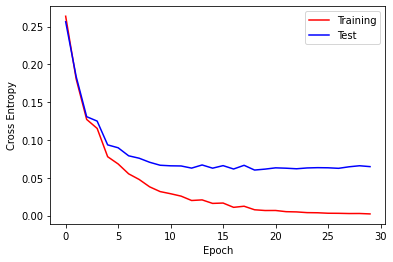

In [11]:
import matplotlib.pyplot as plt

plt.plot([t[0] for t in learn_history],'r',label='Training')
plt.plot([t[2] for t in learn_history],'b',label='Test')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

### Adam

In [1]:
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as trans

class Adam:
    def __init__(self,paras,lr=0.1,beta1=0.9,beta2=0.999,eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.theta_state = list(paras)
        self.m_state = []
        self.v_state = []
        self.num_iters = 0

    def zero_grad(self):
        for theta in self.theta_state:
            if theta.grad is not None:
                theta.grad.zero_()

    def step(self):
        r"""
        调用这步之前，系统关于每个参数的导数要计算完成。
        """
        self.num_iters += 1
        if len(self.m_state)==0:
            self.m_state = [t.data.clone().zero_() for t in self.theta_state]
            self.v_state = [t.data.clone().zero_() for t in self.theta_state]

        for m,v,theta in zip(self.m_state,self.v_state,self.theta_state):
            g = theta.grad.data
            m.mul_(self.beta1).add_(1-self.beta1,g) # 更新梯度的一阶矩
            v.mul_(self.beta2).addcmul_(1-self.beta2,g,g) # 更新梯度的二阶矩

            # 偏差较正
            bias_corr1 = 1 - self.beta1**self.num_iters
            bias_corr2 = 1 - self.beta2**self.num_iters

            # 因为在初期 bias_corr2非常小，直接做下面的运算会导致溢出
            # 一个较为稳定的做法是等价的更新学习率
            # m.div_(bias_corr1)  
            # v.div_(bias_corr2)

            lr = self.lr* math.sqrt(bias_corr2)/bias_corr1 # 自适应学习率

            theta.data.addcdiv_(-lr,m,v.sqrt().add(self.eps))
            
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 100

train_set = dsets.MNIST(root='./data/mnist/',
                        transform=trans.ToTensor(),
                        train=True)
test_set = dsets.MNIST(root='./data/mnist/',
                       transform=trans.ToTensor(),
                       train=False)
train_dl = torch.utils.data.DataLoader(train_set,
                                       batch_size = BATCH_SIZE,
                                       shuffle=True,
                                      num_workers=6)
test_dl = torch.utils.data.DataLoader(test_set,
                                      batch_size= BATCH_SIZE,
                                     num_workers=6)

model = nn.Sequential(nn.Linear(784,500),
                     nn.ReLU(),
                     nn.Linear(500,300),
                     nn.ReLU(),
                     nn.Linear(300,10)).to(device)
criterion = nn.CrossEntropyLoss()

def eval(model,criterion,dataloader):
    loss = 0
    accuracy = 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.view(-1,784)

        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.item()

        probs,pred_y = logits.data.max(dim=1)
        accuracy += (pred_y==batch_y.data).sum().double()/batch_y.size(0)

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy


optimizer = Adam(model.parameters(),lr=0.001)
nepochs = 30

# 记录学习过程
learn_history = []

# 训练
for epoch in range(nepochs):
    since = time.time()
    for batch_x,batch_y in train_dl:
        batch_x = batch_x.view(-1,784)

        optimizer.zero_grad()
        logits = model(batch_x)
        error = criterion(logits,batch_y)
        error.backward()
        optimizer.step()

    now = time.time()
    tr_loss, tr_acc = eval(model,criterion,train_dl)
    te_loss, te_acc = eval(model,criterion,test_dl)
    print('[%3d/%d, %.0f seconds]| train error: %.1e, train acc: %.2f |\t test error: %.1e, test acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))
    learn_history.append((tr_loss,tr_acc,te_loss,te_acc))

<ipython-input-1-b0f4458ed81c>:38: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  m.mul_(self.beta1).add_(1-self.beta1,g) # 更新梯度的一阶矩


[  1/30, 6 seconds]| train error: 1.0e-01, train acc: 97.04 |	 test error: 1.1e-01, test acc: 96.61
[  2/30, 7 seconds]| train error: 5.9e-02, train acc: 98.21 |	 test error: 8.3e-02, test acc: 97.33
[  3/30, 7 seconds]| train error: 4.0e-02, train acc: 98.73 |	 test error: 7.6e-02, test acc: 97.51
[  4/30, 7 seconds]| train error: 3.2e-02, train acc: 98.99 |	 test error: 7.1e-02, test acc: 97.72
[  5/30, 7 seconds]| train error: 2.2e-02, train acc: 99.36 |	 test error: 6.9e-02, test acc: 98.01
[  6/30, 6 seconds]| train error: 1.2e-02, train acc: 99.66 |	 test error: 6.8e-02, test acc: 98.10
[  7/30, 6 seconds]| train error: 1.3e-02, train acc: 99.58 |	 test error: 6.4e-02, test acc: 98.26
[  8/30, 7 seconds]| train error: 1.3e-02, train acc: 99.60 |	 test error: 8.0e-02, test acc: 98.13
[  9/30, 7 seconds]| train error: 2.6e-02, train acc: 99.16 |	 test error: 1.0e-01, test acc: 97.69
[ 10/30, 7 seconds]| train error: 8.8e-03, train acc: 99.73 |	 test error: 8.3e-02, test acc: 98.05


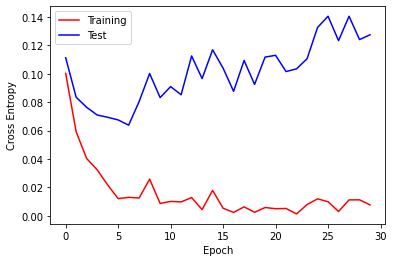

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([t[0] for t in learn_history],'r',label='Training')
plt.plot([t[2] for t in learn_history],'b',label='Test')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend();

### 正则化

In [3]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as trans

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cross-Entropy作为损失函数
criterion = nn.CrossEntropyLoss()

# 加载数据
batch_size = 100
train_set = dsets.MNIST(root='./data/mnist/',transform=trans.ToTensor(),train=True)
test_set = dsets.MNIST(root='./data/mnist/',transform=trans.ToTensor(),train=False)

## 为了突出正则化的效果，我们这里减少训练集的大小 # 运行错误……
train_set.data = train_set.data[0:1000]
train_set.targets = train_set.targets[0:1000]
# train_set.train_data = train_set.train_data[0:1000]
# train_set.train_labels = train_set.train_labels[0:1000]

train_dl = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)#,num_workers=6)
test_dl = torch.utils.data.DataLoader(test_set,batch_size=batch_size)#,num_workers=6)


# 定义训练的辅助函数
def eval(model,criterion,dataloader):
    model.eval()
    loss, accuracy = 0,0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.view(-1,784).to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.item()

        probs,pred_y = logits.data.max(dim=1)
        accuracy += (pred_y==batch_y.data).sum().double()/batch_y.size(0)

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

def train_epoch(net,criterion,optimizer,dataloader):
    for batch_x,batch_y in dataloader:
        batch_x = batch_x.view(-1,784).to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = net(batch_x)
        error = criterion(logits,batch_y)
        error.backward()
        optimizer.step()
        
        
net = nn.Linear(100,2).to(device)
optimizer = torch.optim.SGD(net.parameters(),
                           lr=0.1,
                           weight_decay=1e-4)

# 全连接， 不使用Batch Normalization
net1 = nn.Sequential(nn.Linear(784,500),
                       nn.ReLU(),
                       nn.Linear(500,500),
                       nn.ReLU(),
                       nn.Linear(500,500),
                       nn.ReLU(),
                       nn.Linear(500,10)).to(device)

# 网络结构同上，但是使用 Batch Normalization
net2 = nn.Sequential(nn.Linear(784,500),
                       nn.ReLU(),
                       nn.BatchNorm1d(500),
                       nn.Linear(500,500),
                       nn.ReLU(),
                       nn.BatchNorm1d(500),
                       nn.Linear(500,500),
                       nn.ReLU(),
                       nn.BatchNorm1d(500),
                       nn.Linear(500,10)).to(device)

optimizer1 = torch.optim.SGD(net1.parameters(),lr=0.1,momentum=0.9)
optimizer2 = torch.optim.SGD(net2.parameters(),lr=0.1,momentum=0.9)
learn_hist1 = []
learn_hist2 = []
nepochs = 15

# 训练网络1
print('开始训练使用普通网络.....')
for epoch in range(nepochs):
    since = time.time()
    train_epoch(net1,criterion,optimizer1,train_dl)
    tr_loss, tr_acc = eval(net1,criterion,train_dl)
    te_loss, te_acc = eval(net1,criterion,test_dl)
    learn_hist1.append((tr_loss,tr_acc,te_loss,te_acc))
    now = time.time()
    print('[%3d/%d, %.0f seconds]| train error: %.1e, train acc: %.2f |\t test error: %.1e, test acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))

print('\n开始训练使用Batch Normalization的网络....')
for epoch in range(nepochs):
    since = time.time()
    train_epoch(net2,criterion,optimizer2,train_dl)
    tr_loss, tr_acc = eval(net2,criterion,train_dl)
    te_loss, te_acc = eval(net2,criterion,test_dl)
    learn_hist2.append((tr_loss,tr_acc,te_loss,te_acc))
    now = time.time()
    print('[%3d/%d, %.0f seconds]| train error: %.1e, train acc: %.2f |\t test error: %.1e, test acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))
""" 运行结果：

"""

开始训练使用普通网络.....
[  1/15, 1 seconds]| train error: 2.3e+00, train acc: 23.30 |	 test error: 2.3e+00, test acc: 21.01
[  2/15, 1 seconds]| train error: 1.9e+00, train acc: 56.30 |	 test error: 2.0e+00, test acc: 51.67
[  3/15, 1 seconds]| train error: 1.2e+00, train acc: 57.90 |	 test error: 1.5e+00, test acc: 53.87
[  4/15, 1 seconds]| train error: 7.9e-01, train acc: 77.80 |	 test error: 9.0e-01, test acc: 72.73
[  5/15, 1 seconds]| train error: 3.7e-01, train acc: 87.90 |	 test error: 5.7e-01, test acc: 82.33
[  6/15, 1 seconds]| train error: 2.4e-01, train acc: 92.20 |	 test error: 4.8e-01, test acc: 85.45
[  7/15, 1 seconds]| train error: 1.3e-01, train acc: 95.70 |	 test error: 4.6e-01, test acc: 86.00
[  8/15, 1 seconds]| train error: 6.8e-02, train acc: 98.00 |	 test error: 4.7e-01, test acc: 86.78
[  9/15, 1 seconds]| train error: 9.7e-02, train acc: 96.70 |	 test error: 6.2e-01, test acc: 84.38
[ 10/15, 1 seconds]| train error: 6.3e-02, train acc: 98.00 |	 test error: 5.7e-01, 

' 运行结果：\n\n'

Text(0, 0.5, 'Accuracy')

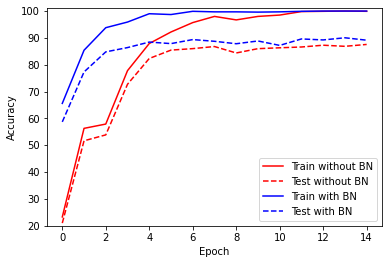

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([t[1] for t in learn_hist1],'r',label='Train without BN')
plt.plot([t[3] for t in learn_hist1],'r--',label='Test without BN')

plt.plot([t[1] for t in learn_hist2],'b',label='Train with BN')
plt.plot([t[3] for t in learn_hist2],'b--',label='Test with BN')

plt.ylim([20,101])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [11]:
Width = 10000
p = 0.85
net3 = nn.Sequential(nn.Linear(784,Width),
                        nn.Dropout(p),
                       nn.ReLU(),
                       nn.Linear(Width,Width),
                       nn.Dropout(p),
                       nn.ReLU(),
                       nn.Linear(Width,10)).to(device)

optimizer3 = torch.optim.SGD(net3.parameters(),lr=0.1,momentum=0.9)
learn_hist3 = []
nepochs = 20

# 训练网络
print('开始训练使用使用Dropout的普通网络.....')
for epoch in range(nepochs):
    since = time.time()
    train_epoch(net3,criterion,optimizer3,train_dl)
    tr_loss, tr_acc = eval(net3,criterion,train_dl)
    te_loss, te_acc = eval(net3,criterion,test_dl)
    learn_hist3.append((tr_loss,tr_acc,te_loss,te_acc))
    now = time.time()
    print('[%3d/%d, %.0f seconds]| train error: %.1e, train acc: %.2f |\t test error: %.1e, test acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))
net3.zero_grad()

开始训练使用使用Dropout的普通网络.....
[  1/20, 2 seconds]| train error: 1.4e+00, train acc: 65.90 |	 test error: 1.6e+00, test acc: 61.66
[  2/20, 2 seconds]| train error: 3.7e-01, train acc: 87.90 |	 test error: 5.7e-01, test acc: 82.01
[  3/20, 2 seconds]| train error: 3.0e-01, train acc: 90.20 |	 test error: 6.7e-01, test acc: 80.75
[  4/20, 2 seconds]| train error: 7.2e-02, train acc: 98.30 |	 test error: 4.1e-01, test acc: 87.78
[  5/20, 2 seconds]| train error: 3.0e-02, train acc: 99.50 |	 test error: 3.8e-01, test acc: 89.53
[  6/20, 2 seconds]| train error: 1.2e-02, train acc: 100.00 |	 test error: 4.3e-01, test acc: 88.33
[  7/20, 2 seconds]| train error: 6.2e-03, train acc: 100.00 |	 test error: 4.2e-01, test acc: 89.55
[  8/20, 2 seconds]| train error: 2.9e-03, train acc: 100.00 |	 test error: 3.9e-01, test acc: 90.30
[  9/20, 2 seconds]| train error: 1.9e-03, train acc: 100.00 |	 test error: 4.1e-01, test acc: 89.82
[ 10/20, 2 seconds]| train error: 1.2e-03, train acc: 100.00 |	 test e

In [12]:
net4 = nn.Sequential(nn.Linear(784,Width),
                       nn.ReLU(),
                       nn.Linear(Width,Width),
                       nn.ReLU(),
                       nn.Linear(Width,10)).to(device)

optimizer4 = torch.optim.SGD(net4.parameters(),lr=0.1,momentum=0.9)
learn_hist4 = []
nepochs = 20


"""
Width = 10000
p = 0.85
net3 = nn.Sequential(nn.Linear(784,Width),
                        nn.Dropout(p),
                       nn.ReLU(),
                       nn.Linear(Width,Width),
                       nn.Dropout(p),
                       nn.ReLU(),
                       nn.Linear(Width,10)).to(device)

optimizer3 = torch.optim.SGD(net3.parameters(),lr=0.1,momentum=0.9)
learn_hist3 = []
nepochs = 20
"""

# 训练网络
print('开始训练使用普通网络.....')
for epoch in range(nepochs):
    since = time.time()
    train_epoch(net4,criterion,optimizer4,train_dl)
    tr_loss, tr_acc = eval(net4,criterion,train_dl)
    te_loss, te_acc = eval(net4,criterion,test_dl)
    learn_hist4.append((tr_loss,tr_acc,te_loss,te_acc))
    now = time.time()
    print('[%3d/%d, %.0f seconds]| train error: %.1e, train acc: %.2f |\t test error: %.1e, test acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))

开始训练使用普通网络.....
[  1/20, 2 seconds]| train error: 7.7e-01, train acc: 77.90 |	 test error: 8.7e-01, test acc: 74.24
[  2/20, 2 seconds]| train error: 5.2e-01, train acc: 84.80 |	 test error: 7.7e-01, test acc: 77.51
[  3/20, 2 seconds]| train error: 2.7e-01, train acc: 91.60 |	 test error: 6.0e-01, test acc: 81.85
[  4/20, 2 seconds]| train error: 1.6e-01, train acc: 94.70 |	 test error: 5.3e-01, test acc: 84.14
[  5/20, 2 seconds]| train error: 9.4e-02, train acc: 97.60 |	 test error: 5.4e-01, test acc: 85.16
[  6/20, 2 seconds]| train error: 1.7e-02, train acc: 100.00 |	 test error: 4.0e-01, test acc: 88.89
[  7/20, 2 seconds]| train error: 7.6e-03, train acc: 100.00 |	 test error: 4.3e-01, test acc: 88.59
[  8/20, 2 seconds]| train error: 4.3e-03, train acc: 100.00 |	 test error: 4.3e-01, test acc: 89.20
[  9/20, 2 seconds]| train error: 3.2e-03, train acc: 100.00 |	 test error: 4.4e-01, test acc: 89.06
[ 10/20, 2 seconds]| train error: 2.3e-03, train acc: 100.00 |	 test error: 4.5e

Text(0, 0.5, 'Accuracy')

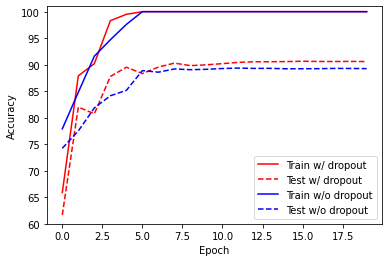

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([t[1] for t in learn_hist3],'r',label='Train w/ dropout')
plt.plot([t[3] for t in learn_hist3],'r--',label='Test w/ dropout')

plt.plot([t[1] for t in learn_hist4],'b',label='Train w/o dropout')
plt.plot([t[3] for t in learn_hist4],'b--',label='Test w/o dropout')

plt.ylim([60,101])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### 数据增强

In [1]:
import time
import torch 
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as trans
BATCH_SIZE = 100
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean = [x/255 for x in [125.3,123.0,113.9]]
std = [x/255 for x in [63.0,62.1,66.7]]
n_train_samples = 50000

# 不做数据增强
train_set = dsets.CIFAR10(root='./data/cifar10',
                          train=True,
                          transform=trans.Compose([
                              trans.ToTensor(),
                              trans.Normalize(mean,std)
                          ]))
train_set.data = train_set.data[0:n_train_samples]
train_set.targets = train_set.targets[0:n_train_samples]
train_dl = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=6)

# 数据增强
train_set_ag = dsets.CIFAR10(root='./data/cifar10',
                          train=True,
                          transform=trans.Compose([
                              trans.RandomHorizontalFlip(), # 以p=0.5的概率随机水平翻转图片
                              trans.RandomCrop(32,padding=4), # 在图片的边界补零并输出size=32的图片
                              trans.ToTensor(),
                              trans.Normalize(mean,std)
                          ]))
train_set_ag.data = train_set_ag.data[0:n_train_samples]
train_set_ag.targets = train_set_ag.targets[0:n_train_samples]
train_dl_ag = DataLoader(train_set_ag,batch_size=BATCH_SIZE,shuffle=True,num_workers=6)


# 测试集一样
test_set = dsets.CIFAR10(root='./data/cifar10',
                         train=False,
                         transform=trans.Compose([
                             trans.ToTensor(),
                             trans.Normalize(mean,std)
                         ]))
test_dl = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

def eval(model,criterion,dataloader):
    model.eval()
    loss = 0
    accuracy = 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        error = criterion(logits,batch_y)
        loss += error.item()

        probs,pred_y = logits.data.max(dim=1)
        accuracy += (pred_y==batch_y.data).sum().double()/batch_y.size(0)

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy

def train_epoch(net,criterion,optimizer,dataloader):
    for batch_x,batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = net(batch_x)
        error = criterion(logits,batch_y)
        error.backward()
        optimizer.step()

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3,50,kernel_size=5,padding=2),
            nn.AvgPool2d(4),
            nn.ReLU(),
            nn.Conv2d(50,50,kernel_size=5,padding=2),
            nn.AvgPool2d(2),
            nn.ReLU())
        self.classifier = nn.Sequential(
            nn.Linear(50*4*4,500),
            nn.ReLU(),
            nn.Linear(500,10))

    def forward(self,x):
        o = self.feature(x)
        o = o.view(-1,50*4*4)
        o = self.classifier(o)
        return o

nepochs = 60

net = LeNet().to(device)

optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[40],gamma=0.1)
learn_hist = []


net_ag = LeNet().to(device)

optimizer_ag = torch.optim.Adam(net_ag.parameters(),lr=0.001)
scheduler_ag = lr_scheduler.MultiStepLR(optimizer,milestones=[40],gamma=0.1)
learn_hist_ag = []

print('开始使用正常数据训练网络.....')
for epoch in range(nepochs):
    since = time.time()
    train_epoch(net,criterion,optimizer,train_dl)
    tr_loss, tr_acc = eval(net,criterion,train_dl)
    te_loss, te_acc = eval(net,criterion,test_dl)
    learn_hist.append((tr_loss,tr_acc,te_loss,te_acc))
    now = time.time()
    if (epoch+1)%5 == 0:
        print('[%d/%d, %.0f seconds], tr_err: %.1e, tr_acc: %.2f\t te_err: %.1e, te_acc: %.2f'%(
            epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))


print('\n 开始使用数据增强训练网络.....')
for epoch in range(nepochs):
    since = time.time()
    scheduler_ag.step()
    train_epoch(net_ag,criterion,optimizer_ag,train_dl_ag)
    tr_loss, tr_acc = eval(net_ag,criterion,train_dl_ag)
    te_loss, te_acc = eval(net_ag,criterion,test_dl)
    learn_hist_ag.append((tr_loss,tr_acc,te_loss,te_acc))
    now = time.time()

    if (epoch+1)%5==0:
        print('[%d/%d, %.0f seconds], tr_err: %.1e, tr_acc: %.2f\t te_err: %.1e, te_acc: %.2f'%(
                epoch+1,nepochs,now-since,tr_loss,tr_acc,te_loss,te_acc))

开始使用正常数据训练网络.....
[5/60, 69 seconds], tr_err: 8.3e-01, tr_acc: 70.97	 te_err: 1.1e+00, te_acc: 61.76
[10/60, 68 seconds], tr_err: 3.8e-01, tr_acc: 87.51	 te_err: 1.2e+00, te_acc: 63.58
[15/60, 68 seconds], tr_err: 1.6e-01, tr_acc: 94.59	 te_err: 1.9e+00, te_acc: 62.03
[20/60, 71 seconds], tr_err: 9.0e-02, tr_acc: 96.90	 te_err: 2.5e+00, te_acc: 61.43
[25/60, 71 seconds], tr_err: 8.6e-02, tr_acc: 97.05	 te_err: 2.9e+00, te_acc: 61.98
[30/60, 70 seconds], tr_err: 6.5e-02, tr_acc: 97.74	 te_err: 3.2e+00, te_acc: 61.98
[35/60, 72 seconds], tr_err: 8.1e-02, tr_acc: 97.39	 te_err: 3.6e+00, te_acc: 61.51
[40/60, 73 seconds], tr_err: 3.4e-02, tr_acc: 98.83	 te_err: 3.7e+00, te_acc: 61.82
[45/60, 71 seconds], tr_err: 6.4e-02, tr_acc: 97.93	 te_err: 3.9e+00, te_acc: 61.39
[50/60, 69 seconds], tr_err: 6.2e-02, tr_acc: 98.10	 te_err: 4.1e+00, te_acc: 61.25
[55/60, 64 seconds], tr_err: 4.5e-02, tr_acc: 98.56	 te_err: 4.5e+00, te_acc: 62.12
[60/60, 63 seconds], tr_err: 6.2e-02, tr_acc: 98.22	 te_err

Text(0, 0.5, 'Accuracy')

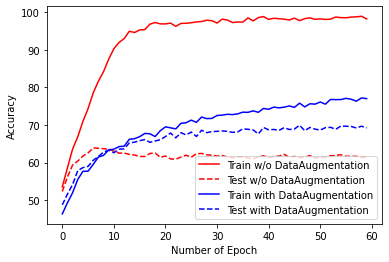

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([t[1] for t in learn_hist],'r',label='Train w/o DataAugmentation')
plt.plot([t[3] for t in learn_hist],'r--',label='Test w/o DataAugmentation')

plt.plot([t[1] for t in learn_hist_ag],'b',label='Train with DataAugmentation')
plt.plot([t[3] for t in learn_hist_ag],'b--',label='Test with DataAugmentation')

plt.legend()
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')